# Tartan Data Science Cup
    
    - Problem: Binary Classification on user's loan_status [Good or Bad]
    - Team : Anything Random
    - Members : Nikita Gupta, Maria Rodriguez, Kweonwoo Jung
    - Prize : AppleTV + USD50 per participant
    - Period: Feb 04 2017 9AM ~ 6PM 

In [1]:
# data manipulation
import pandas as pd
import numpy as np
import operator

# machine learning (preprocessing, k-fold cross-validation, model training, evaluation)
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss
from sklearn.preprocessing import LabelEncoder

# xgboost
import xgboost as xgb

# plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data Preparation
    - load data
    - check loan_status histogram
    - binarize the target column : 'loan_status'

In [2]:
# load data
data = pd.read_csv('../input/train.csv')
tst  = pd.read_csv('../input/test.csv')

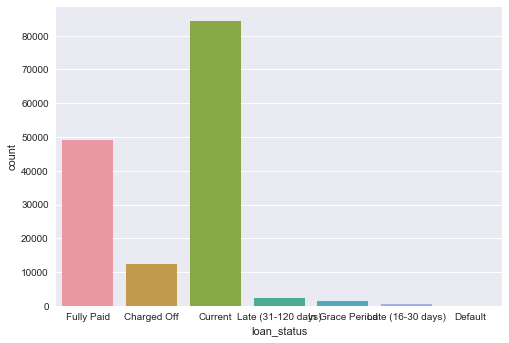

In [3]:
# check loan_status histogram
sns.countplot(data['loan_status'])

In [4]:
# convert 'loan_status' into binary

col = 'loan_status'
positives = ['Fully Paid','Current','In Grace Period']
y = np.zeros(data.shape[0])

for i, row in enumerate(data[col]):
    if row not in positives:
        y[i] = 1    
        
print('# Ratio of positives : {0:.4}% out of 150k'.format((y.sum()/y.shape)[0]))

# Ratio of positives : 0.1014% out of 150k


# Preprocessing & Feature Engineering
    - converting categorical variables into numeric variables, preserving the order if necessary
    - additional feature engineering
        - distance between today and issue_d, earliest_cr_line
        - annual_income into bin

In [5]:
# converting categorical variables into numeric
features = []

# term
col = 'term'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# int_rate
col = 'int_rate'
data[col] = data[col].apply(lambda x: x[:-1]).astype(np.float32)
tst[col] = tst[col].apply(lambda x: x[:-1]).astype(np.float32)
features.append(col)

# grade
col = 'grade'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# sub_grade
col = 'sub_grade'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# emp_length
col = 'emp_length'
temp = data[col].apply(lambda x: x[:2])
temp.replace('n/', 0, inplace=True)
temp.replace('< ', 0.5, inplace=True)
data[col] = temp.astype(np.float32)
temp = tst[col].apply(lambda x: x[:2])
temp.replace('n/', 0, inplace=True)
temp.replace('< ', 0.5, inplace=True)
tst[col] = temp.astype(np.float32)
features.append(col)

# home_ownership
col = 'home_ownership'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# verification_status
col = 'verification_status'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)


# issue_d
col = 'issue_d'
months_map = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
              'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10,'Nov':11,'Dec':12}
data['issue_m'] = data[col].apply(lambda x: months_map[x[:3]])
tst['issue_m'] = tst[col].apply(lambda x: months_map[x[:3]])
features.append('issue_m')

data['issue_y'] = data[col].apply(lambda x: x[4:]).astype(np.int32)
tst['issue_y'] = tst[col].apply(lambda x: x[4:]).astype(np.int32)
features.append('issue_y')

# purpose
col = 'purpose'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# zip_code
col = 'zip_code'
lb = LabelEncoder()
lb.fit(pd.concat([data[col], tst[col]], axis=0))
data[col] = lb.transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# addr_state
col = 'addr_state'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# earliest_cr_line
col = 'earliest_cr_line'
data['earliest_cr_line_m'] = data[col].apply(lambda x: months_map[x[:3]])
tst['earliest_cr_line_m'] = tst[col].apply(lambda x: months_map[x[:3]])
features.append('earliest_cr_line_m')

data['earliest_cr_line_y'] = data[col].apply(lambda x: x[4:]).astype(np.int32)
tst['earliest_cr_line_y'] = tst[col].apply(lambda x: x[4:]).astype(np.int32)
features.append('earliest_cr_line_y')

# revol_util
col = 'revol_util'
data[col] = data[col].apply(lambda x: str(x).replace('%','')).astype(np.float32).fillna(0)
tst[col] = tst[col].apply(lambda x: str(x).replace('%','')).astype(np.float32).fillna(0)
features.append(col)

# initial_list_status
col = 'initial_list_status'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)

# application_type
col = 'application_type'
lb = LabelEncoder()
data[col] = lb.fit_transform(data[col])
tst[col] = lb.transform(tst[col])
features.append(col)


In [6]:
# additional feature engineering
# distance from today to issue_d and early_cr_line
data['issue_datestamp'] = ((2017 - 1900)*12 + 2) - (data['issue_m'] + (data['issue_y'] - 1900)*12)
data['early_cr_datestamp'] = ((2017 - 1900)*12 + 2) - (data['earliest_cr_line_m'] + (data['earliest_cr_line_y'] - 1990)*12)
tst['issue_datestamp'] = ((2017 - 1900)*12 + 2) - (tst['issue_m'] + (tst['issue_y'] - 1900)*12)
tst['early_cr_datestamp'] = ((2017 - 1900)*12 + 2) - (tst['earliest_cr_line_m'] + (tst['earliest_cr_line_y'] - 1990)*12)
features.append('issue_datestamp')
features.append('early_cr_datestamp')

def to_bin(x):
    if x < 10000: return 1
    elif x < 30000: return 2
    elif x < 60000: return 3
    elif x < 90000: return 4
    elif x < 120000: return 5
    else: return 6

# annual_inc in bin
col = 'annual_inc'
data['annual_inc_bin'] = data[col].apply(lambda x: to_bin(x))
tst['annual_inc_bin'] = tst[col].apply(lambda x: to_bin(x))
features.append('annual_inc_bin')

# outlier clipping
# dti clip > 99 to 100
data.loc[data['dti'] > 99, 'dti'] = 100
tst.loc[tst['dti'] > 99, 'dti'] = 100

# pub_rec clipt >20 to 20
data.loc[data['pub_rec'] > 20,'pub_rec'] = 20
tst.loc[tst['pub_rec'] > 20,'pub_rec'] = 20

# Model Evlauation
    - Benchmark Brier score is 0.1014 for All Zero submission
    - Evaluting base model with 3-fold cross-validation
        - evaluate on trn/vld data to avoid overfitting
        - evaluate linear(logistic regression), tree(random forest, extra trees, xgboost)
        - evaluate Brier, AUC, Logloss scores

In [7]:
# benchmark evaluation values for Brier scores to refer

# all zero
bench_m = np.zeros(data.shape[0])
print('# All Zero')
print('\tBrier   : {0:.4f}'.format(brier_score_loss(y, bench_m)))
print('\tAUC     : {0:.4f}'.format(roc_auc_score(y, bench_m)))
print('\tLogloss : {0:.4f}\n'.format(log_loss(y, bench_m)))

# all 0.5
bench_m += 0.5
print('# All 0.5')
print('\tBrier   : {0:.4f}'.format(brier_score_loss(y, bench_m)))
print('\tAUC     : {0:.4f}'.format(roc_auc_score(y, bench_m)))
print('\tLogloss : {0:.4f}\n'.format(log_loss(y, bench_m)))

# all 1.0
bench_m += 0.5
print('# All One')
print('\tBrier   : {0:.4f}'.format(brier_score_loss(y, bench_m)))
print('\tAUC     : {0:.4f}'.format(roc_auc_score(y, bench_m)))
print('\tLogloss : {0:.4f}\n'.format(log_loss(y, bench_m)))

# All Zero
	Brier   : 0.1014
	AUC     : 0.5000
	Logloss : 3.5032

# All 0.5
	Brier   : 0.2500
	AUC     : 0.5000
	Logloss : 0.6931

# All One
	Brier   : 0.8986
	AUC     : 0.5000
	Logloss : 31.0363



In [8]:
# add numeric features to complete feature set
features.extend(['loan_amnt', 'installment', 'annual_inc', 'dti' ,'delinq_2yrs', 'inq_last_6mths', 'open_acc',
            'pub_rec', 'total_acc'])

In [11]:
# extract data 
trn = data.as_matrix(columns=features)

# empty lists for storing evaluation results
trn_bri = []; vld_bri = []
trn_auc = []; vld_auc = []
trn_log = []; vld_log = []

# 3-fold cross validation
skf = StratifiedKFold(n_splits=3)
for trn_index, vld_index in skf.split(trn, y):
    
    # split data into trn/vld
    x_trn, x_vld = trn[trn_index], trn[vld_index]
    y_trn, y_vld = y[trn_index], y[vld_index]
    
    # model fit
    model = RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=777)
    # model = LogisticRegression(C=1, n_jobs=-1)
    # model = ExtraTreesClassifier(max_depth=10, n_jobs=-1, random_state=777)
    model.fit(x_trn, y_trn)

    # evaluate trn scores
    trn_pred = model.predict_proba(x_trn)[:,1]
    trn_bri.append(brier_score_loss(y_trn, trn_pred))
    trn_auc.append(roc_auc_score(y_trn, trn_pred))
    trn_log.append(log_loss(y_trn, trn_pred))
    
    # evaluate vld scores
    vld_pred = model.predict_proba(x_vld)[:,1]
    vld_bri.append(brier_score_loss(y_vld, vld_pred))
    vld_auc.append(roc_auc_score(y_vld, vld_pred))
    vld_log.append(log_loss(y_vld, vld_pred))
    
# print evaluations on trn/vld 
print('=' * 50)
print(' TRAIN')
print('-' * 50)
print('# Brier   : {0:.4f} + {0:.2f}'.format(np.mean(trn_bri), np.std(trn_bri)))
print('# AUC     : {0:.4f} + {0:.2f}'.format(np.mean(trn_auc), np.std(trn_auc)))
print('# Logloss : {0:.4f} + {0:.2f}'.format(np.mean(trn_log), np.std(trn_log)))

print('=' * 50)
print(' VALID')
print('-' * 50)
print('# Brier   : {0:.4f} + {0:.2f}'.format(np.mean(vld_bri), np.std(vld_bri)))
print('# AUC     : {0:.4f} + {0:.2f}'.format(np.mean(vld_auc), np.std(vld_auc)))
print('# Logloss : {0:.4f} + {0:.2f}'.format(np.mean(vld_log), np.std(vld_log)))

 TRAIN
--------------------------------------------------
# Brier   : 0.0860 + 0.09
# AUC     : 0.7223 + 0.72
# Logloss : 0.3004 + 0.30
 VALID
--------------------------------------------------
# Brier   : 0.0860 + 0.09
# AUC     : 0.7218 + 0.72
# Logloss : 0.3006 + 0.30


# XGBoost modeling

In [13]:
# extract data 
trn = data.as_matrix(columns=features)

# empty lists for storing evaluation results
trn_bri = []; vld_bri = []
trn_auc = []; vld_auc = []
trn_log = []; vld_log = []

# store best ntree iteration 
best_ntree = []

# xgboost parameter
param = {
        'objective': 'binary:logistic',
        'eta': 0.02,
        'min_child_weight': 10,
        'max_depth': 5,
        'silent': 1,
        'eval_metric': 'auc',
        'colsample_bytree': 0.8,
        'colsample_bylevel': 0.8,
    }

# 3-fold cross validation
skf = StratifiedKFold(n_splits=3)
for trn_index, vld_index in skf.split(trn, y):
    
    # split data into trn/vld
    x_trn, x_vld = trn[trn_index], trn[vld_index]
    y_trn, y_vld = y[trn_index], y[vld_index]
    
    # convert to xgboost data format
    dtrn = xgb.DMatrix(x_trn, label=y_trn, feature_names=features)
    dvld = xgb.DMatrix(x_vld, label=y_vld, feature_names=features)
    
    # train model
    evallist  = [(dtrn,'train'), (dvld,'eval')]
    xgb_model = xgb.train(param, dtrn, 1000, evals=evallist, early_stopping_rounds=20)    
    
    # record best_iteration count
    best_ntree_limit = xgb_model.best_ntree_limit
    best_ntree.append(best_ntree_limit)
    
    # trn scores
    trn_pred = xgb_model.predict(dtrn)
    trn_bri.append(brier_score_loss(y_trn, trn_pred))
    trn_auc.append(roc_auc_score(y_trn, trn_pred))
    trn_log.append(log_loss(y_trn, trn_pred))
    
    # vld scores
    vld_pred = xgb_model.predict(dvld)
    vld_bri.append(brier_score_loss(y_vld, vld_pred))
    vld_auc.append(roc_auc_score(y_vld, vld_pred))
    vld_log.append(log_loss(y_vld, vld_pred))
    

# print evaluations on trn/vld 
print('=' * 50)
print(' TRAIN')
print('-' * 50)
print('# Brier   : {0:.4f} + {0:.2f}'.format(np.mean(trn_bri), np.std(trn_bri)))
print('# AUC     : {0:.4f} + {0:.2f}'.format(np.mean(trn_auc), np.std(trn_auc)))
print('# Logloss : {0:.4f} + {0:.2f}'.format(np.mean(trn_log), np.std(trn_log)))

print('=' * 50)
print(' VALID')
print('-' * 50)
print('# Brier   : {0:.4f} + {0:.2f}'.format(np.mean(vld_bri), np.std(vld_bri)))
print('# AUC     : {0:.4f} + {0:.2f}'.format(np.mean(vld_auc), np.std(vld_auc)))
print('# Logloss : {0:.4f} + {0:.2f}'.format(np.mean(vld_log), np.std(vld_log)))

[0]	train-auc:0.733048	eval-auc:0.729978
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 20 rounds.
[1]	train-auc:0.73614	eval-auc:0.731921
[2]	train-auc:0.738371	eval-auc:0.733851
[3]	train-auc:0.738494	eval-auc:0.733798
[4]	train-auc:0.738619	eval-auc:0.734444
[5]	train-auc:0.739448	eval-auc:0.734829
[6]	train-auc:0.739557	eval-auc:0.734948
[7]	train-auc:0.739586	eval-auc:0.734919
[8]	train-auc:0.739826	eval-auc:0.734816
[9]	train-auc:0.740078	eval-auc:0.735275
[10]	train-auc:0.740184	eval-auc:0.735361
[11]	train-auc:0.740066	eval-auc:0.73502
[12]	train-auc:0.740267	eval-auc:0.73521
[13]	train-auc:0.740248	eval-auc:0.735314
[14]	train-auc:0.740693	eval-auc:0.735759
[15]	train-auc:0.740697	eval-auc:0.735705
[16]	train-auc:0.740823	eval-auc:0.735859
[17]	train-auc:0.740889	eval-auc:0.736045
[18]	train-auc:0.740972	eval-auc:0.73604
[19]	train-auc:0.741135	eval-auc:0.736028
[20]	train-auc:0.741208	eval-auc:

# Visualization
    - retrieve feature importance and plot
        - for random forest model
        - for linear (logistic regression) model
        - for xgboost model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)
--------------------------------------------------
# Sorted Feature Importance
     0.25455 	 int_rate
     0.20537 	 issue_datestamp
     0.19704 	 sub_grade
     0.16178 	 grade
     0.0496 	 issue_y
     0.02537 	 initial_list_status
     0.01404 	 term
     0.01385 	 annual_inc
     0.0105 	 dti
     0.0103 	 installment
     0.00891 	 inq_last_6mths
     0.00853 	 home_ownership
     0.00673 	 verification_status
     0.00564 	 revol_util
     0.00433 	 issue_m
     0.0042 	 loan_amnt
     0.00416 	 zip_code
     0.00297 	 total_acc
     0.00248 	 emp_length
     0.00243 	 annual_inc_bin
     0.00214 	 early

[<matplotlib.text.Text at 0x10a4b82e8>, <matplotlib.text.Text at 0x10a4b7ef0>]

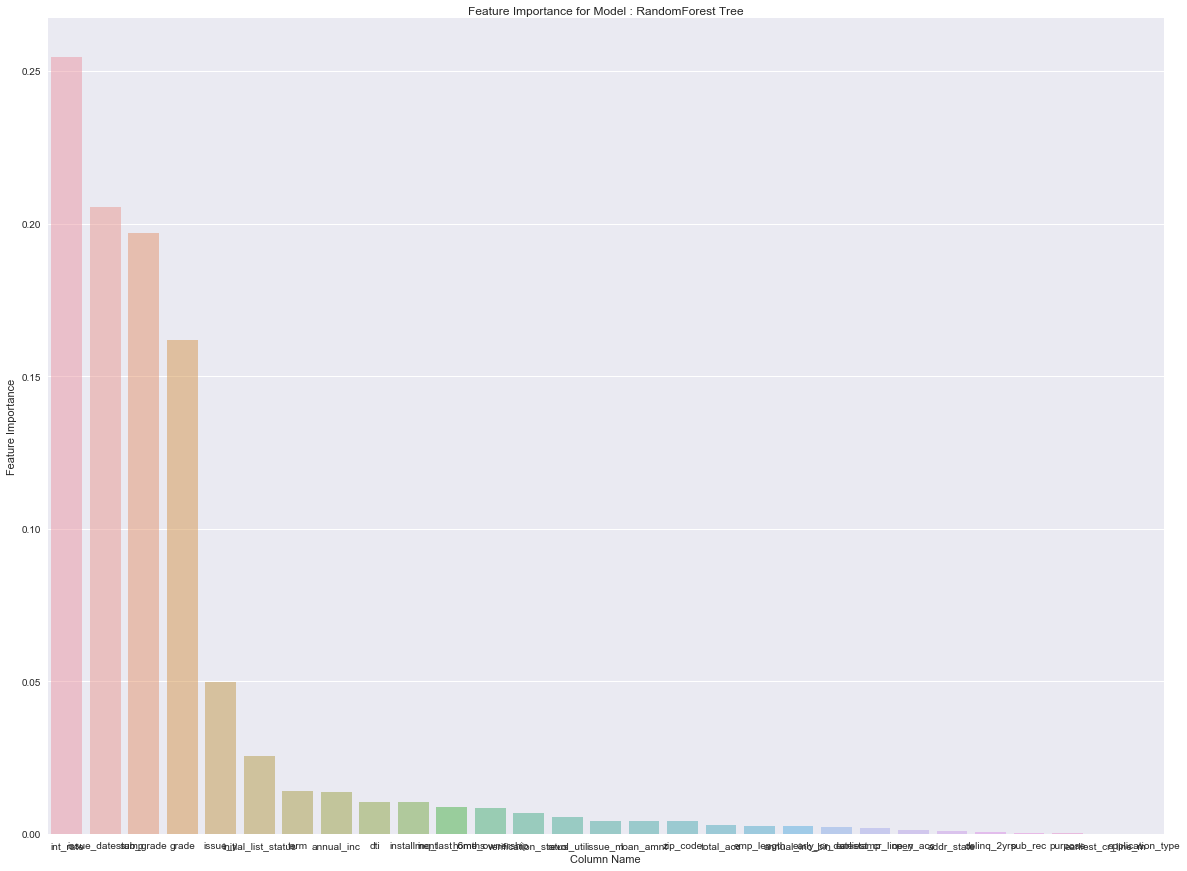

In [10]:
# RandomForest

print('='*50)
print(model)

feature_importance = dict()
for i, f_imp in enumerate(model.feature_importances_):
    feature_importance[features[i]] = f_imp

print('-'*50)
print('# Sorted Feature Importance')
feature_importance_sorted = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse=True)
prefix = '    '
for item in feature_importance_sorted:
    print('{} {} \t {}'.format(prefix, round(item[1],5), item[0]))

# plot
fimp = feature_importance_sorted
plot_x = []; plot_y = []
for item in fimp:
    plot_x.append(item[0])
    plot_y.append(item[1])

f, ax = plt.subplots(figsize=(20, 15))
sns.barplot(plot_x,plot_y,alpha=0.5)
ax.set_title('Feature Importance for Model : RandomForest Tree')
ax.set(xlabel='Column Name', ylabel='Feature Importance')

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
# Coefficients for target_num == 0
[  1.92333335e-03   4.22229222e-02   1.22926023e-02   6.31065420e-02
  -6.86249543e-03   8.26496929e-03   2.67342726e-03  -1.31424273e-03
  -2.03613663e-03   2.28283155e-03  -1.34659823e-04  -6.11443473e-04
  -1.64397987e-03  -1.76189397e-05  -1.37824332e-04  -1.36172575e-03
  -7.65863334e-05   2.38126153e-02  -1.66205706e-04  -1.80165056e-03
  -1.06375869e-05   5.64428753e-04  -2.41429263e-06   1.13638696e-02
   9.84977985e-04   6.01624806e-03   3.25050241e-03   5.96005706e-04
   2.10382489e-03]
--------------------------------------------------
# Sorted Feature Importance
     0.06311 	 sub_grade
     0.04222 	 int_rate
     0.02381 	 issue_datestamp
     0.01229 	 grade
     0.01136 	 dti


[<matplotlib.text.Text at 0x10ae84630>, <matplotlib.text.Text at 0x10b339080>]

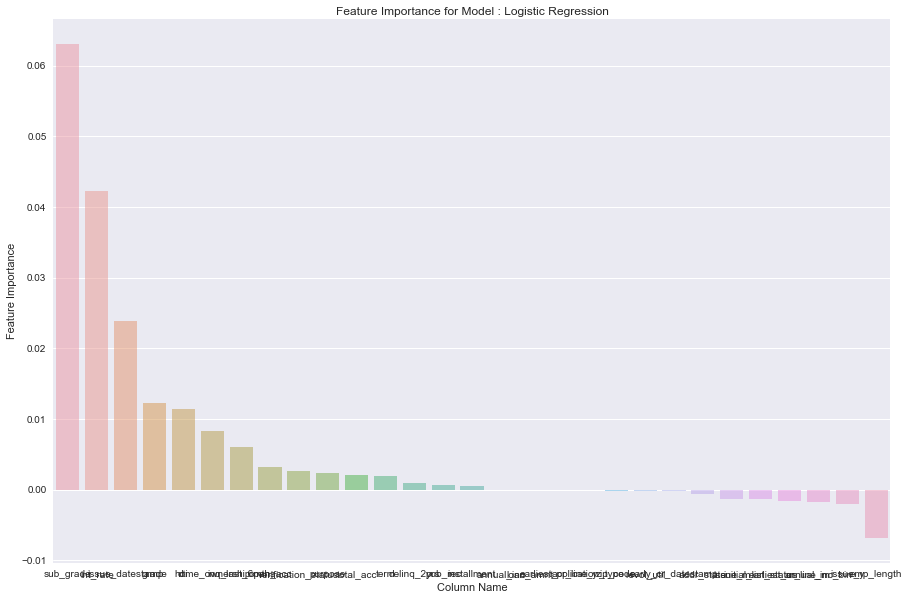

In [12]:
# Logistic Regression

target_num = 0
print('='*50)
print(model)

print('='*50)
print('# Coefficients for target_num == {}'.format(target_num))
print(model.coef_[target_num])

feature_importance = dict()
for i, f_imp in enumerate(model.coef_[target_num]):
    feature_importance[features[i]] = f_imp

print('-'*50)
print('# Sorted Feature Importance')
coefs_sorted = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse=True)
for item in coefs_sorted:
    print('{} {} \t {}'.format(prefix, round(item[1],5), item[0]))

plot_x = []; plot_y = []
for item in coefs_sorted:
    plot_x.append(item[0])
    plot_y.append(item[1])

f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(plot_x,plot_y,alpha=0.5)
ax.set_title('Feature Importance for Model : Logistic Regression')
ax.set(xlabel='Column Name', ylabel='Feature Importance')

# Feature importance_xgboost

--------------------------------------------------
# Sorted Feature Importance
     1574 	 issue_datestamp
     1160 	 int_rate
     1083 	 annual_inc
     1011 	 installment
     995 	 dti
     749 	 sub_grade
     722 	 zip_code
     672 	 revol_util
     599 	 early_cr_datestamp
     593 	 total_acc
     585 	 loan_amnt
     465 	 emp_length
     459 	 issue_m
     408 	 open_acc
     383 	 inq_last_6mths
     313 	 addr_state
     306 	 home_ownership
     264 	 issue_y
     251 	 purpose
     195 	 grade
     172 	 earliest_cr_line_m
     155 	 earliest_cr_line_y
     124 	 term
     108 	 delinq_2yrs
     98 	 verification_status
     76 	 pub_rec
     75 	 initial_list_status
     73 	 annual_inc_bin
     34 	 application_type


[<matplotlib.text.Text at 0x10bca5cc0>, <matplotlib.text.Text at 0x10bc9aef0>]

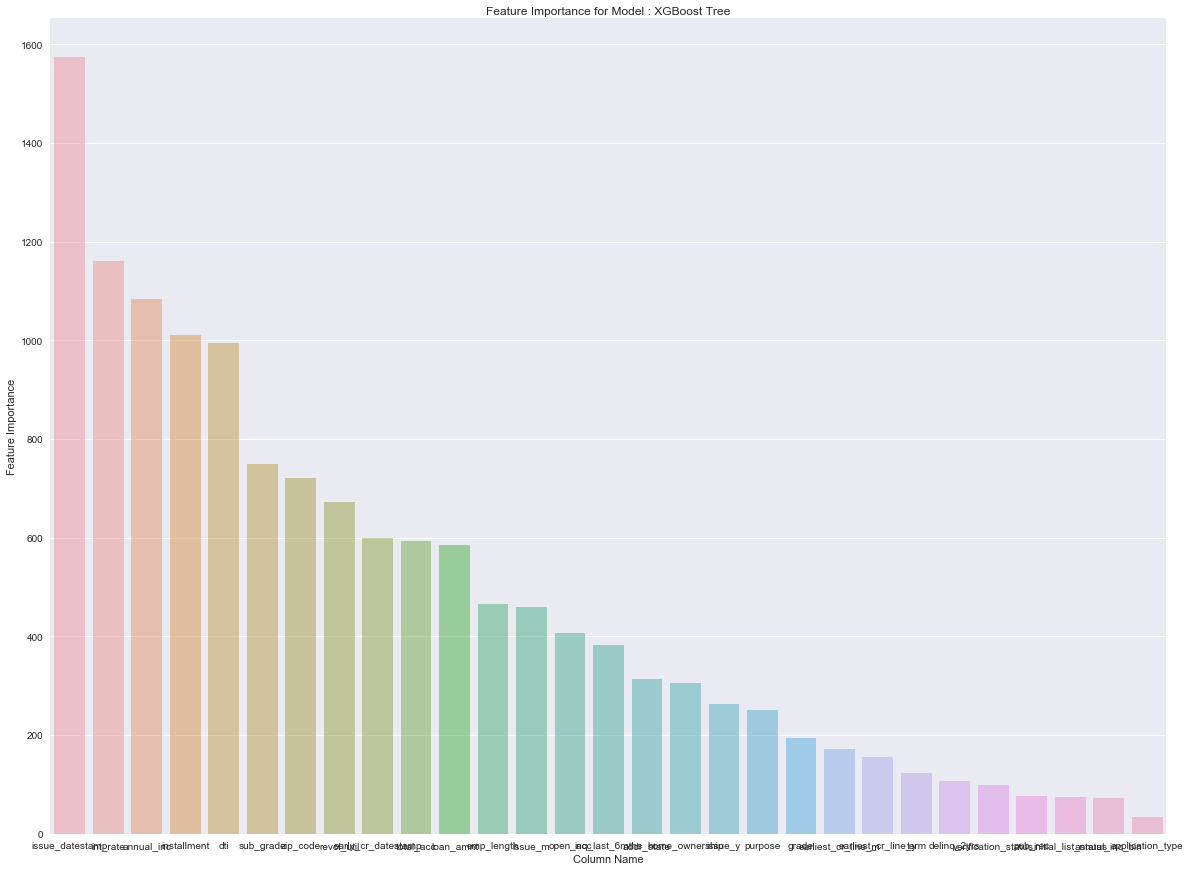

In [15]:
print('='*50)

print('-'*50)
print('# Sorted Feature Importance')
feature_importance_sorted = sorted(xgb_model.get_fscore().items(), key=operator.itemgetter(1), reverse=True)
prefix = '    '
for item in feature_importance_sorted:
    print('{} {} \t {}'.format(prefix, round(item[1],5), item[0]))

# plot
fimp = feature_importance_sorted
plot_x = []; plot_y = []
for item in fimp:
    plot_x.append(item[0])
    plot_y.append(item[1])

f, ax = plt.subplots(figsize=(20, 15))
sns.barplot(plot_x,plot_y,alpha=0.5)
ax.set_title('Feature Importance for Model : XGBoost Tree')
ax.set(xlabel='Column Name', ylabel='Feature Importance')

# outlier detection
    - feature wise histogram used to observe the spread and detect outlier
        - annual_inc, dti had skewed distribution with extreme values

# Col : term


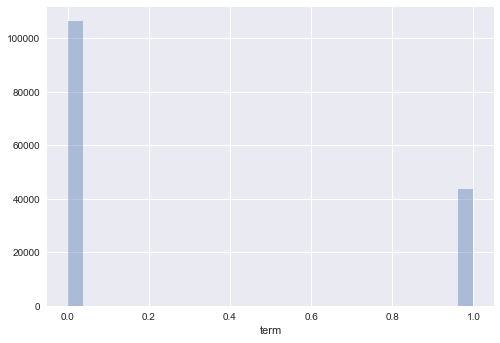

# Col : int_rate


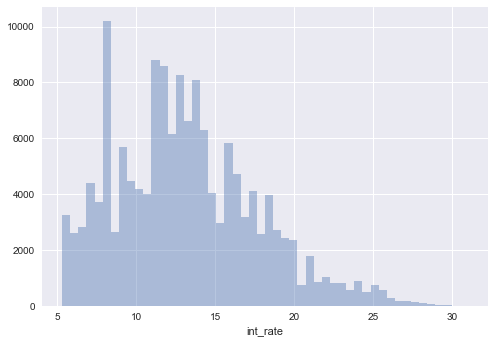

# Col : grade


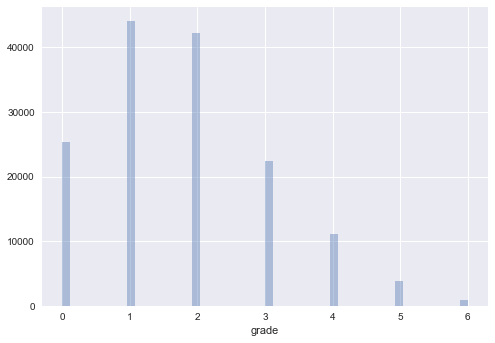

# Col : sub_grade


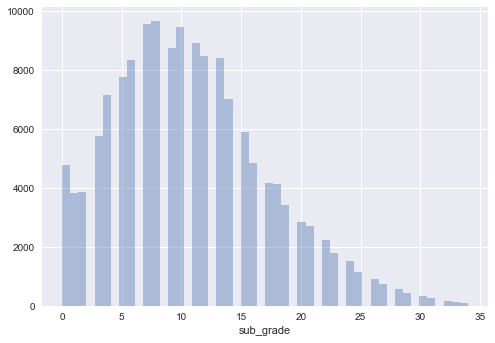

# Col : emp_length


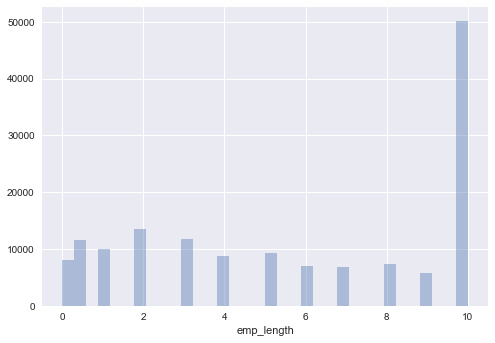

# Col : home_ownership


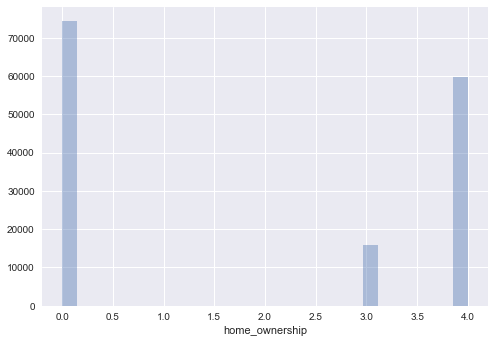

# Col : verification_status


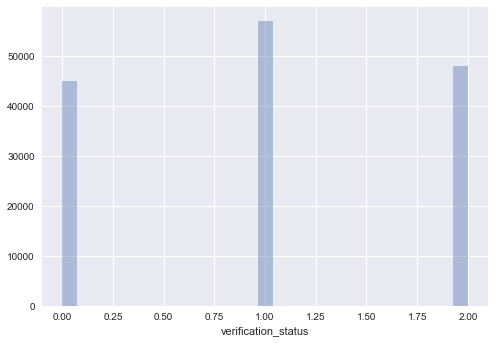

# Col : issue_m


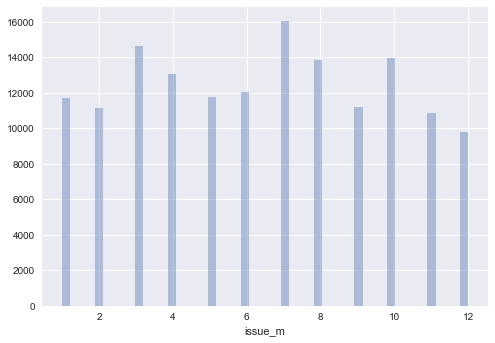

# Col : issue_y


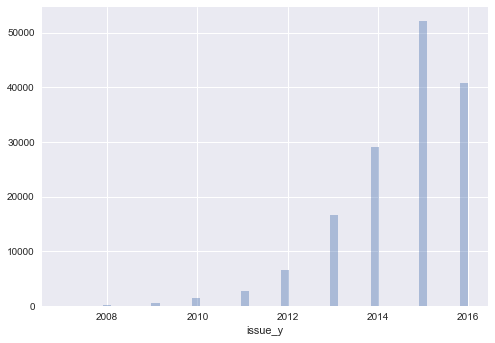

# Col : purpose


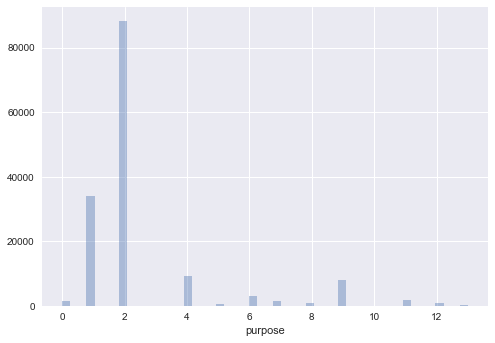

# Col : zip_code


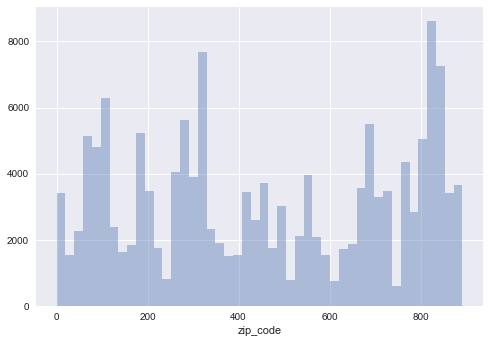

# Col : addr_state


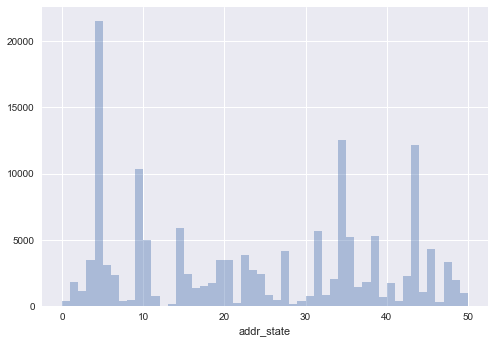

# Col : earliest_cr_line_m


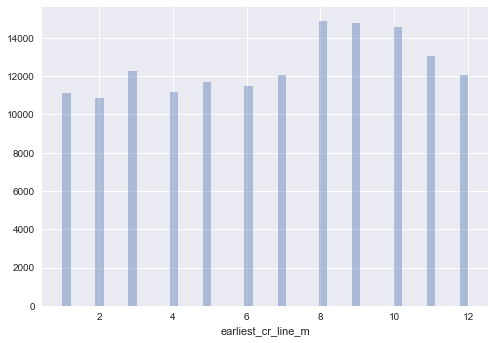

# Col : earliest_cr_line_y


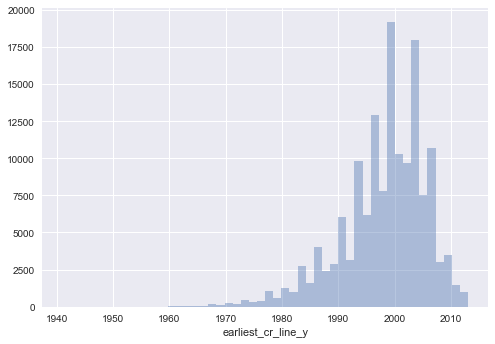

# Col : revol_util


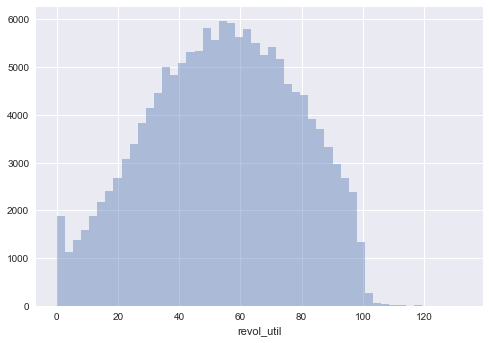

# Col : initial_list_status


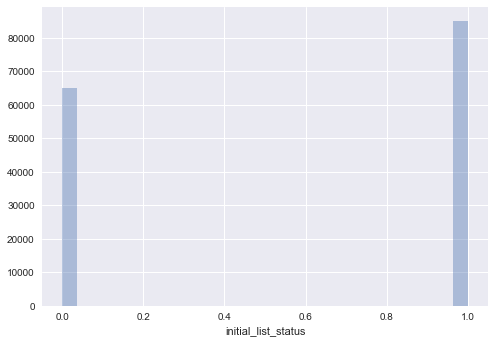

# Col : application_type


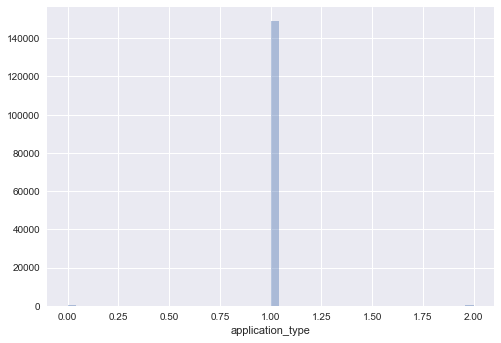

# Col : issue_datestamp


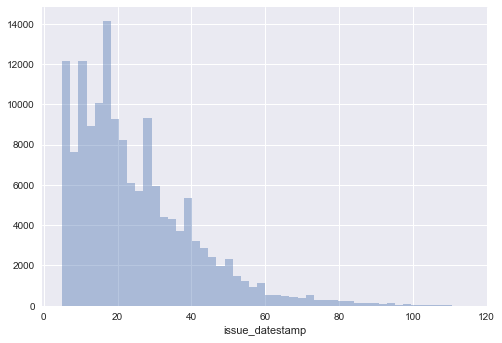

# Col : early_cr_datestamp


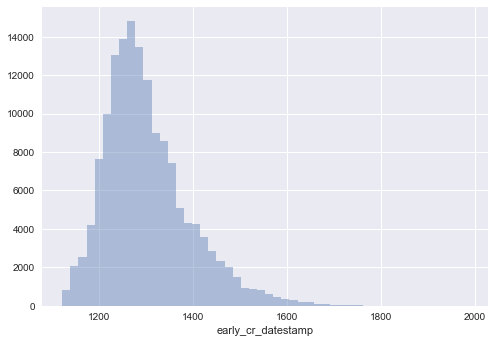

# Col : annual_inc_bin


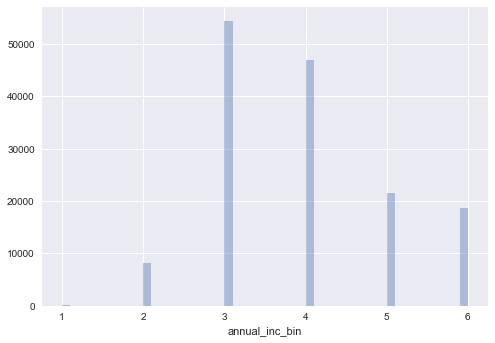

# Col : loan_amnt


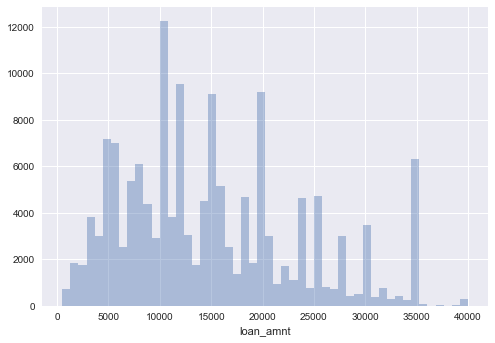

# Col : installment


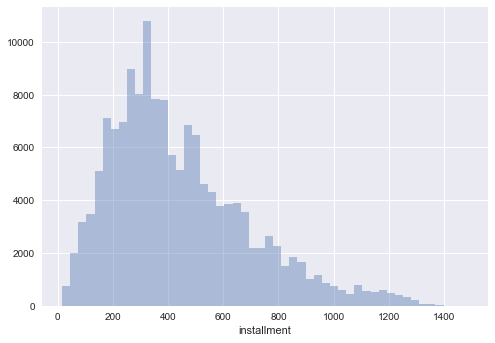

# Col : annual_inc


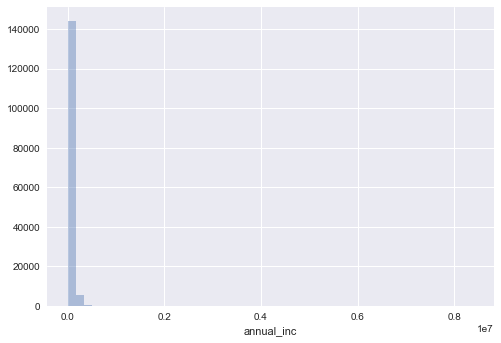

# Col : dti


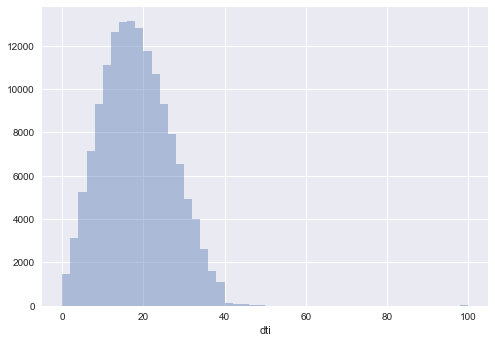

# Col : delinq_2yrs


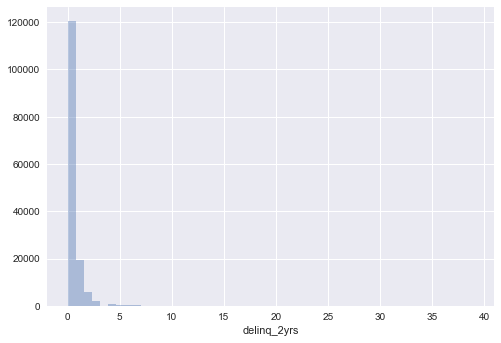

# Col : inq_last_6mths


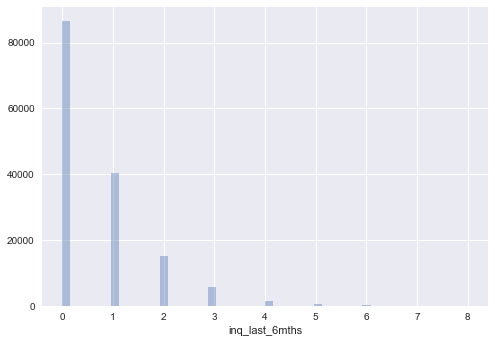

# Col : open_acc


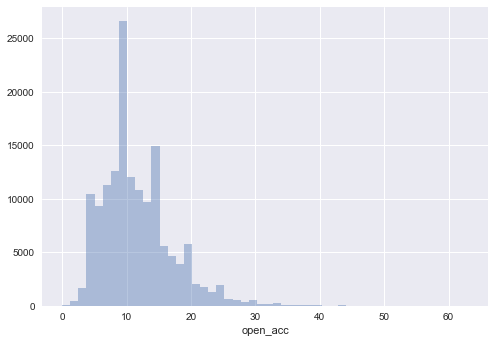

# Col : pub_rec


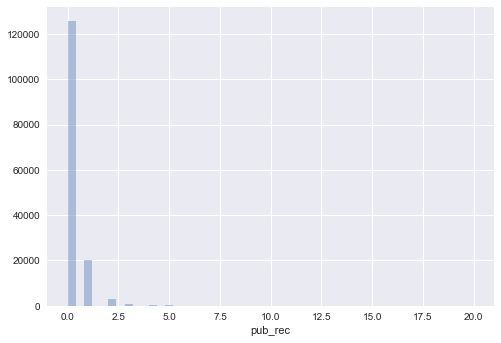

# Col : total_acc


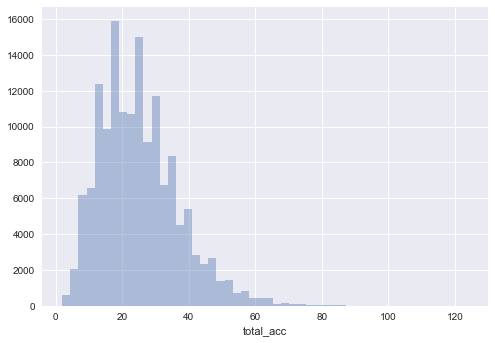

In [16]:
for feature in features:
    print('# Col : {}'.format(feature))
    sns.distplot(data[feature], kde=False)
    plt.show()

In [17]:
# single data observation
data.loc[122]

id                                                              40531664
member_id                                                       43396438
loan_amnt                                                          12000
funded_amnt                                                        12000
funded_amnt_inv                                                    12000
term                                                                   0
int_rate                                                            8.19
installment                                                       376.89
grade                                                                  0
sub_grade                                                              4
emp_title                                               MACHINE OPERATOR
emp_length                                                            10
home_ownership                                                         4
annual_inc                                         

# Making submission

In [ ]:
# fit all data
model.fit(trn, y)

# make prediction on test
prediction = model.predict_proba(tst.as_matrix(columns=features))[:,1]

# output to file
submission = pd.DataFrame(prediction, columns=['prediction'])
filename = '../output/anything_random_valid_{0:.4f}.csv'.format(np.mean(vld_bri))
submission.to_csv(filename, index=False)

In [ ]:
# fit all data
dtrn = xgb.DMatrix(data.as_matrix(columns=features), label=y, feature_names=features)
model = xgb.train(param, dtrn, int(np.mean(best_ntree)*1.5))
    
# make prediction on test
dtst = xgb.DMatrix(tst.as_matrix(columns=features), feature_names=features)
prediction = model.predict(dtst)

# output to file
submission = pd.DataFrame(prediction, columns=['prediction'])
filename = '../output/anything_random_valid_{0:.4f}.csv'.format(np.mean(vld_bri))
submission.to_csv(filename, index=False)

# this code generates our final prediction file!

# train-valid-test relationship
    - violin plot of features in trn/vld/tst data
    - visualization confirms that all three data come from similar distribution, implying that the performance of trn/vld can be generalized to test data

col :  term


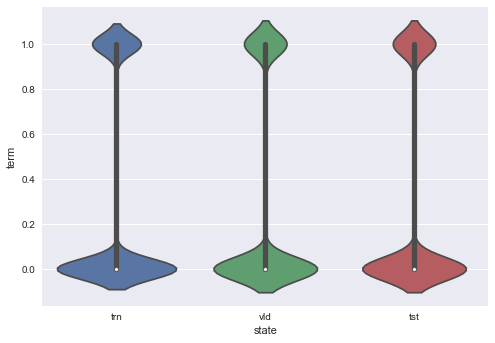

col :  int_rate


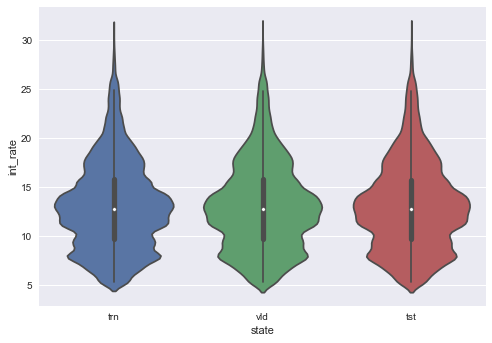

col :  grade


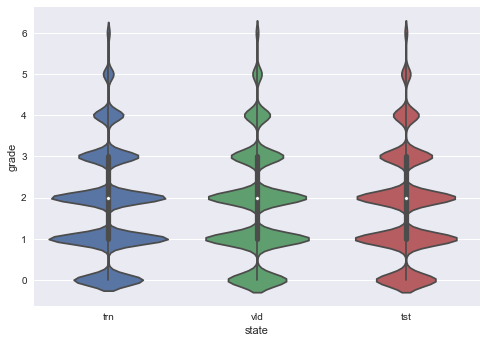

col :  sub_grade


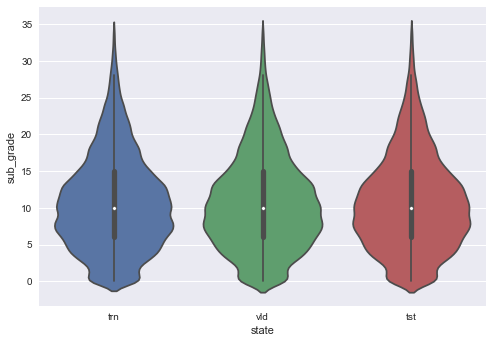

col :  emp_length


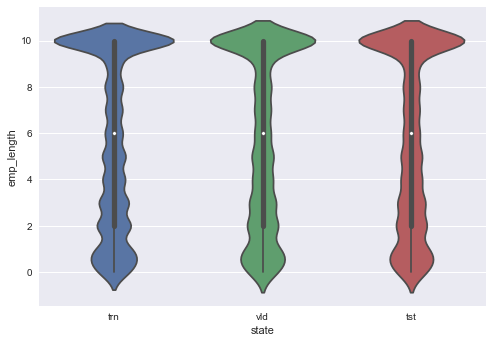

col :  home_ownership


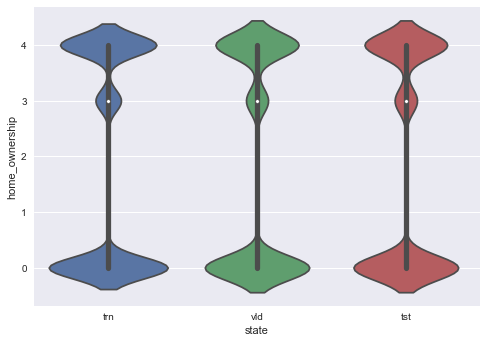

col :  verification_status


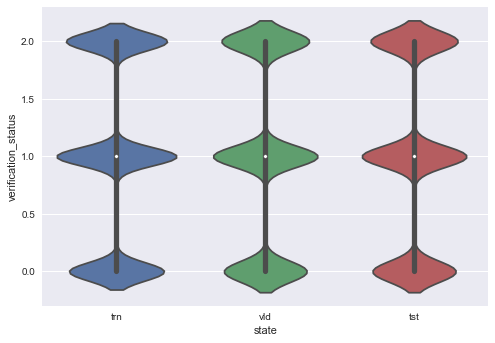

col :  issue_m


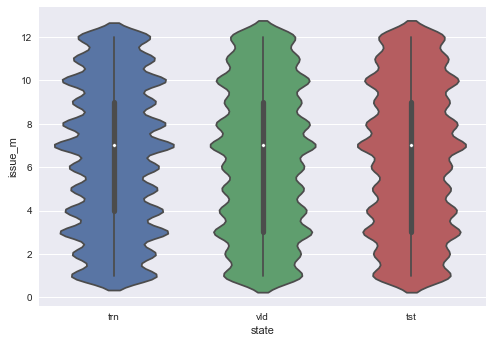

col :  issue_y


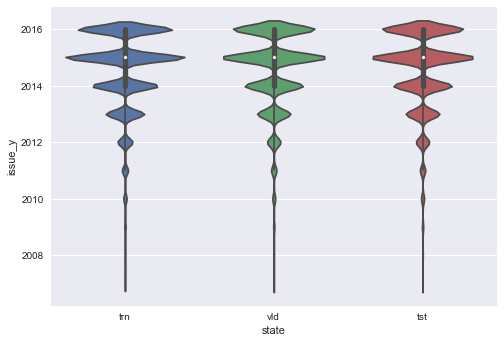

col :  purpose


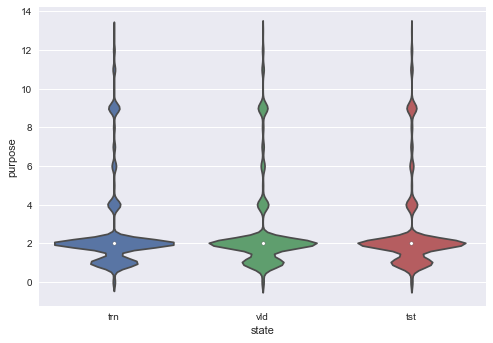

col :  zip_code


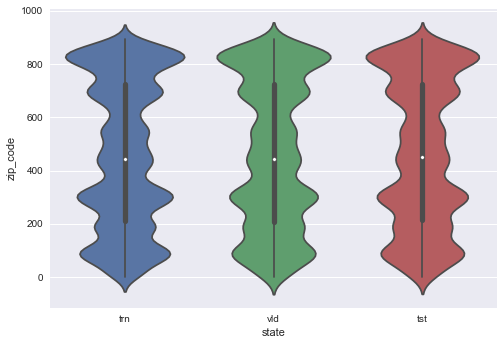

col :  addr_state


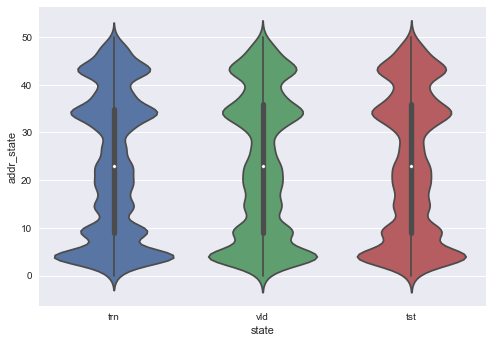

col :  earliest_cr_line_m


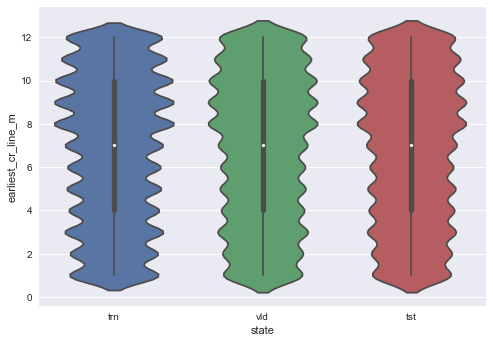

col :  earliest_cr_line_y


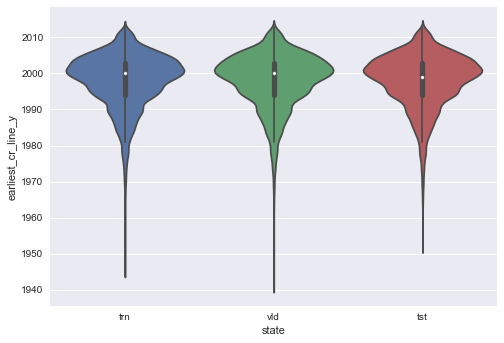

col :  revol_util


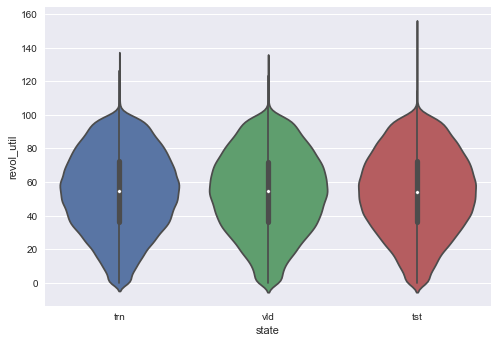

col :  initial_list_status


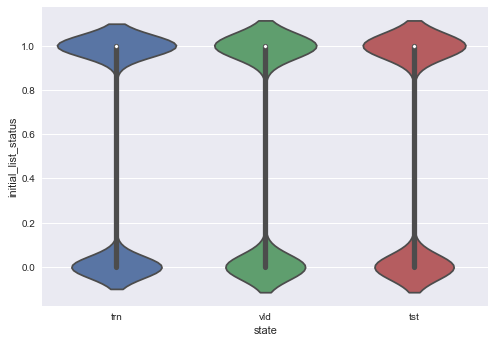

col :  application_type


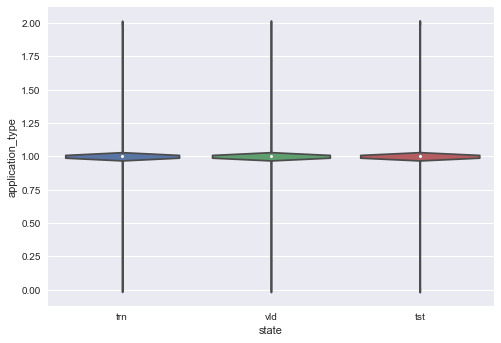

col :  issue_datestamp


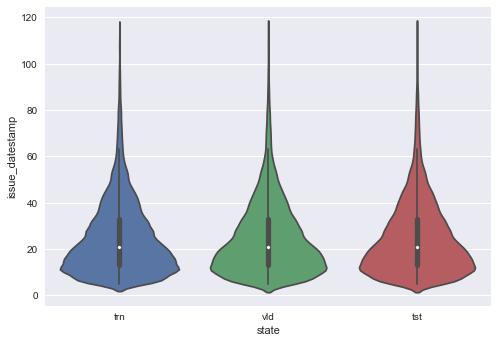

col :  early_cr_datestamp


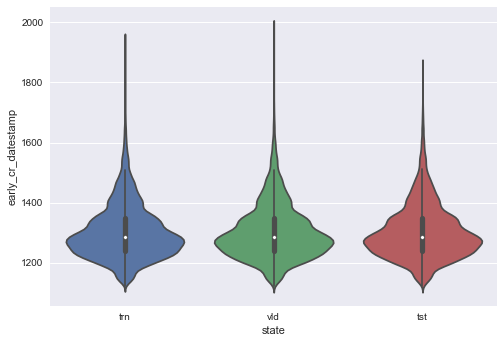

col :  annual_inc_bin


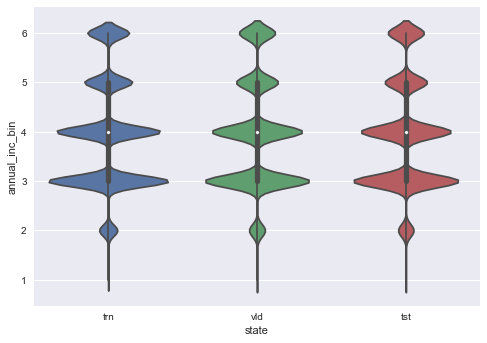

col :  loan_amnt


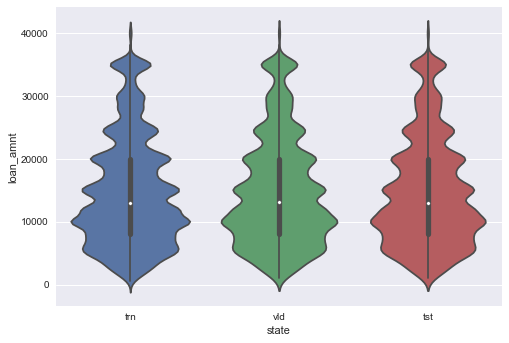

col :  installment


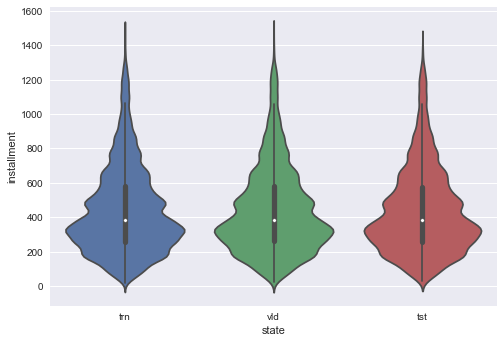

col :  annual_inc


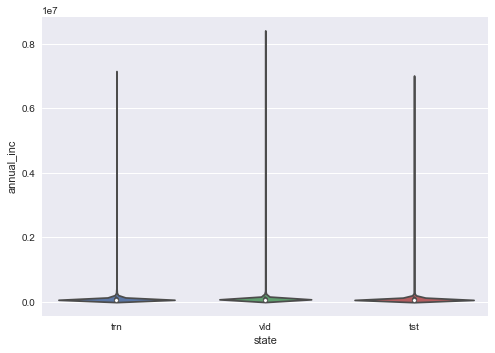

col :  dti


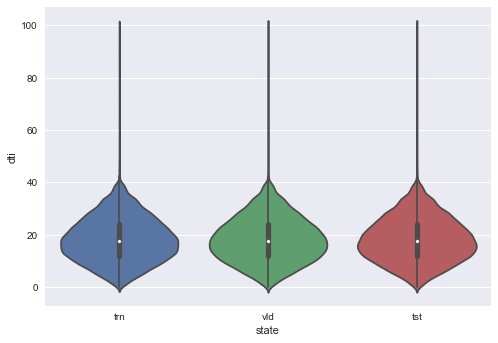

col :  delinq_2yrs


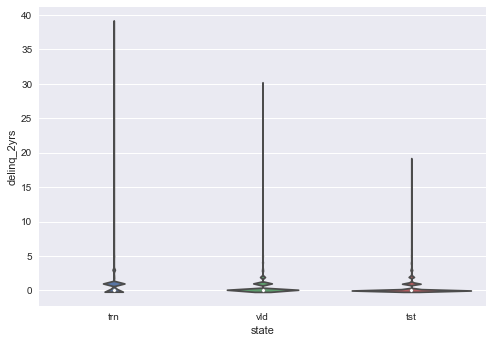

col :  inq_last_6mths


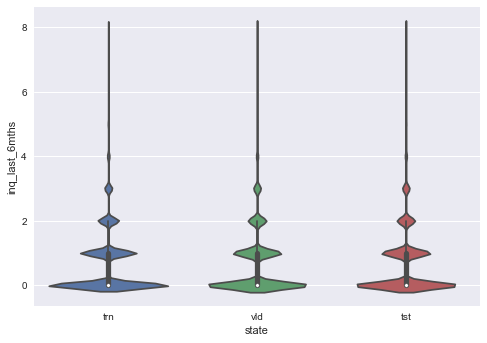

col :  open_acc


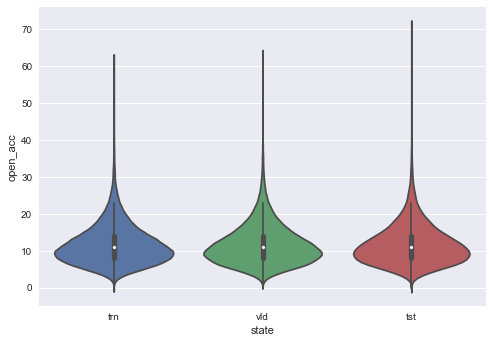

col :  pub_rec


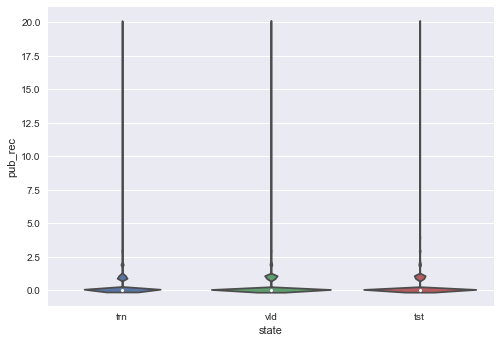

col :  total_acc


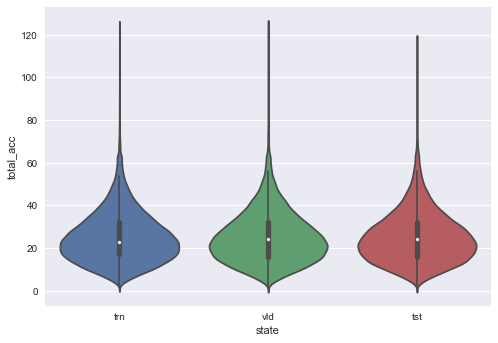

In [18]:
# extract cross-validation split index
skf = StratifiedKFold(n_splits=3)
for trn_index, vld_index in skf.split(trn, y):
    pass
 
# iterate over features for violin plot
for col in features:
    print('='*50)
    print('col : ', col)

    # retrieve trn/vld/tst data
    trn_tmp = pd.DataFrame(data.ix[trn_index, col])
    vld_tmp = pd.DataFrame(data.ix[vld_index, col])
    tst_tmp = pd.DataFrame(tst[col])
    
    # give state label
    trn_tmp['state'] = 'trn'
    vld_tmp['state'] = 'vld'
    tst_tmp['state'] = 'tst'
    
    # concatenate all
    tmp = pd.concat([trn_tmp, vld_tmp, tst_tmp], axis=0)

    # plot
    sns.violinplot(x="state", y=col, data=tmp)
    plt.show()